<a href="https://colab.research.google.com/github/natkor18/Data_Science_yandex_project/blob/main/toxic_comments_on_git/toxic_comments_on_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75.

**Инструкция по выполнению проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели.
3. Сделайть выводы.

Для выполнения проекта применять *BERT* необязательно, но можно попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

План работ:<br/>
1. Считать датасет
2. Провести токенизацию и лемматизацию (без bert)
3. Очистить от стоп слов
4. Преобразовать в векторный формат (мешок слов)
5. Обучить модели на трейне. Посчитать скор (f1)
6. Проверить f1 на тесте

Загрузим необходимые модули

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.utils import shuffle

import nltk
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score

import spacy

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords

from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Ситаем данные, посмотрим на них

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0).reset_index(drop=True)

In [ ]:
pd.options.display.max_colwidth = 999 #выводим полный текст постов, установив максимальную длину.
data.head(5)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Датарейм состоит из более чем 159 тыс. строк, в таблице содержатся комментарии и оценка - положительный или токсичный комментарий. Выполним лемматизацию данных по столбцу 'text'.

Выполню лемматизацию позже с помощью  spacy. А пока почистим текст от лишних символов.


Сделаем функцию для наших целей, апостроф оставим, так как в английском языке много сокращений с этим символом.


In [ ]:
def cleared_text(text):
    clear_text = []
    for item in text:
        corp = ' '.join(re.sub(r"[^a-z'A-Z]", ' ', item.lower()).split())
        clear_text.append(corp)

    return clear_text

In [ ]:
%%time
data['clear_text'] = cleared_text(data['text'])

CPU times: user 4.4 s, sys: 58.5 ms, total: 4.46 s
Wall time: 4.47 s


In [ ]:
data.head()

,text,toxic,clear_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good article nominations transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that's on


In [ ]:
data[data['clear_text'].isnull()]

,text,toxic,clear_text


Ну вот теперь создадим функцию лемматизации и прогоним на ней весь очищенных текст.


In [ ]:
%%time
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 18079000

def lemmatise(text):
    lemmas_text = []
    for line in text:
        lemmas_list = nlp(line)
        line_lemmas_list = " ".join([token.lemma_ for token in lemmas_list])
        lemmas_text.append(line_lemmas_list)
    return lemmas_text

CPU times: user 503 ms, sys: 39.9 ms, total: 543 ms
Wall time: 566 ms


Проверим работоспособость нашей функции, если все ок, то передадим ей наши данные.

In [ ]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
print(lemmatise([sentence1, sentence2]))

['the stripe bat be hang on their foot for good', 'you should be ashamed of yourself go work']


In [ ]:
%%time
data['lemm_text'] = lemmatise(data['clear_text'])

CPU times: user 19min, sys: 7.38 s, total: 19min 8s
Wall time: 19min 8s


Получили новые очищенные данные, их и будем использовать в  качестве признаков для обучения и тестирования моделей.

In [ ]:
data.head()

,text,toxic,clear_text,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now,explanation why the edit make under my username hardcore metallica fan be revert they be not vandalism just closure on some gas after I vote at new york doll fac and please do not remove the template from the talk page since I be retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d'aww he matches this background colour i'm seemingly stuck with thanks talk january utc,d'aww he match this background colour I be seemingly stuck with thank talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i'm really not trying to edit war it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,hey man I be really not try to edit war it be just that this guy be constantly remove relevant information and talk to I through edit instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can't make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it's listed in the relevant form eg wikipedia good article nominations transport,more I can not make any real suggestion on improvement I wonder if the section statistic should be later on or a subsection of type of accident I think the reference may need tidy so that they be all in the exact same format ie date format etc I can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let I know there appear to be a backlog on article for review so I guess there may be a delay until a reviewer turn up it be list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that's on,you sir be my hero any chance you remember what page that be on


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159292 non-null  object
 1   toxic       159292 non-null  int64 
 2   clear_text  159292 non-null  object
 3   lemm_text   159292 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.9+ MB


Выполним разделение на обучающую и тестовую выборки.

In [ ]:
targets = data['toxic']
features = data['lemm_text']

In [ ]:
targets

0         0
1         0
2         0
3         0
4         0
         ..
159287    0
159288    0
159289    0
159290    0
159291    0
Name: toxic, Length: 159292, dtype: int64

Мы и так знали, какие значения имеет таргетс, убедились, еще раз.

In [ ]:
targets.unique()

array([0, 1])

Выполним разделение на тренировочную и тестовую выборки.

In [ ]:
features_train, features_test, targets_train, targets_test = train_test_split(features,
                                                                              targets,
                                                                              random_state=12345,
                                                                              test_size=0.25,
                                                                              stratify=targets)

In [ ]:
print("Размер тренировочной выборки:",features_train.shape, targets_train.shape)
print("Размер тестовой выборки",features_test.shape, targets_test.shape)

Размер тренировочной выборки: (119469,) (119469,)
Размер тестовой выборки (39823,) (39823,)


In [ ]:
targets_train.size

119469

In [ ]:
targets_train_size = targets_train.value_counts()

print("Положительных отзывов:", targets_train_size[0], "-", round(targets_train_size[0] / 119469 * 100, 2), '%' )
print("Отрицательных отзывов:", targets_train_size[1], "-", round(targets_train_size[1] / 119469 * 100, 2), '%')

Положительных отзывов: 107329 - 89.84 %
Отрицательных отзывов: 12140 - 10.16 %


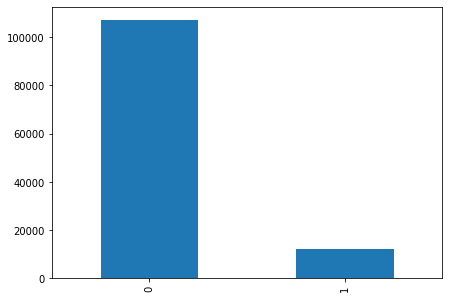

In [ ]:
targets_train_size.plot(kind='bar', figsize=(7,5));

Наблюдается сильный дисбаланс классов.

## Обучение

**Логистическая регрессия**

Выполним векторизацию без стоп-слов. Обучим логистическую модель на кроссвалидации с параметром class_weight = 'balanced'

In [ ]:
stop_words = set(stopwords.words('english'))

 Сделаем сразу векторизацию и для теста

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
features_train_tf_idf = count_tf_idf.fit_transform(features_train) #для обучающей
features_test_tf_idf = count_tf_idf.transform(features_test)  #для тестовой

In [ ]:
features_train_tf_idf.shape, targets_train.shape, features_test_tf_idf.shape, targets_test.shape

((119469, 127710), (119469,), (39823, 127710), (39823,))

Логистическая регрессия GridSearchCv

In [ ]:
%%time
regression = LogisticRegression(fit_intercept=True,
                                random_state=12345,
                                class_weight='balanced',
                                solver='liblinear'
                               )
regression_parametrs = {'C': [0.1, 1, 5]}

regression_grid = GridSearchCV(regression, regression_parametrs, scoring='f1', cv=3)
regression_grid.fit(features_train_tf_idf, targets_train)

CPU times: user 49.6 s, sys: 1min 27s, total: 2min 17s
Wall time: 2min 17s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': [0.1, 1, 5]}, scoring='f1')

In [ ]:
print("Лучшие параметры на логистической регрессии:", regression_grid.best_params_)
print("F1 на логистической регрессии:", regression_grid.best_score_)

Лучшие параметры на логистической регрессии: {'C': 5}
F1 на логистической регрессии: 0.7628288576498196


Логистическая регрессия: pipeline + GridSearchCv

In [ ]:
%%time
pipeline = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                     ("lr", LogisticRegression())])

parameters = {'lr__solver': ['liblinear'],
              'lr__C': (.1, 1, 5, 10),
              'lr__random_state': ([12345]),
              'lr__max_iter': ([200]),
              'lr__class_weight': (['balanced'])}
regression_log_p = GridSearchCV(pipeline, parameters, scoring='f1', cv=2, n_jobs=-1)

regression_log_p.fit(features_train, targets_train)

CPU times: user 1min 23s, sys: 1min 15s, total: 2min 38s
Wall time: 2min 38s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        sublinear_tf=True)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': (0.1, 1, 5, 10),
                         'lr__class_weight': ['balanced'],
                         'lr__max_iter': [200], 'lr__random_state': [12345],
                         'lr__solver': ['liblinear']},
             scoring='f1')

In [ ]:
print("Лучшие параметры на логистической регрессии:", regression_log_p.best_params_)
print('F1 логистической регрессии =', regression_log_p.best_score_)

Лучшие параметры на логистической регрессии: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__max_iter': 200, 'lr__random_state': 12345, 'lr__solver': 'liblinear'}
F1 логистической регрессии = 0.7645567723569591



Случайный лес: pipeline + GridSearchCv


In [ ]:
%%time
pipeline_RFC = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                     ('rf', RandomForestClassifier())])

params_RFC = {'rf__n_estimators': range(5, 100, 15),
                     'rf__max_depth': range(5, 7),
              'rf__class_weight': (['balanced'])}

model_RFC= GridSearchCV(pipeline_RFC, params_RFC, scoring='f1', cv=2, n_jobs=-1)

model_RFC.fit(features_train, targets_train)

CPU times: user 3min 14s, sys: 579 ms, total: 3min 14s
Wall time: 3min 14s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        sublinear_tf=True)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__class_weight': ['balanced'],
                         'rf__max_depth': range(5, 7),
                         'rf__n_estimators': range(5, 100, 15)},
             scoring='f1')

In [ ]:
print("Лучшие параметры на случайном лесе:", model_RFC.best_params_)
print("F1 на случайном лесе:", model_RFC.best_score_)

Лучшие параметры на случайном лесе: {'rf__class_weight': 'balanced', 'rf__max_depth': 6, 'rf__n_estimators': 80}
F1 на случайном лесе: 0.3687657191346533


Случайный лес дает низкое значение f1. Кстати и c class_weight='balanced'  f1 = 0,33 (был) приблизительно, а вот на на oversampling очень даже оптимистично.


Случайный лес на сбалансированном классе дает луший результат. 0.7708336644197963 против 0.3393419408250063 на том же случайном лесе, но с параметром class_weight='balanced'. Будем считать что это ошибочный прогноз.

GradientBoostingClassifier


In [ ]:
%%time
pipeline_GBC = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                     ('gb', GradientBoostingClassifier())])

params_RFC = {'gb__n_estimators': range(5, 50, 5),
              'gb__max_depth': range(3, 5),
              'gb__verbose' : [100]}

model_GBC= GridSearchCV(pipeline_GBC,
                        params_RFC,
                        scoring='f1',
                        cv=2,
                        n_jobs=-1)

model_GBC.fit(features_train, targets_train)

      Iter       Train Loss   Remaining Time 
         1           0.6113            2.50s
         2           0.5897            1.84s
         3           0.5746            1.22s
         4           0.5632            0.61s
         5           0.5509            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6096            2.46s
         2           0.5873            1.78s
         3           0.5735            1.18s
         4           0.5581            0.58s
         5           0.5460            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6113            5.52s
         2           0.5897            4.84s
         3           0.5746            4.16s
         4           0.5632            3.51s
         5           0.5509            2.91s
         6           0.5414            2.32s
         7           0.5343            1.74s
         8           0.5279            1.15s
         9           0.5219            0.58s
       

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        sublinear_tf=True)),
                                       ('gb', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'gb__max_depth': range(3, 5),
                         'gb__n_estimators': range(5, 50, 5),
                         'gb__verbose': [100]},
             scoring='f1')

In [ ]:
print("Лучшие параметры на градиентном бустинге:", model_GBC.best_params_)
print("F1 на градиентном бустинге:", model_GBC.best_score_)

Лучшие параметры на градиентном бустинге: {'gb__max_depth': 4, 'gb__n_estimators': 45, 'gb__verbose': 100}
F1 на градиентном бустинге: 0.5673932518634662


CatBoost: pipline + GridSearchCV


In [ ]:
%%time
pipeline_CtB = Pipeline([("vect", TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                     ('ct', CatBoostClassifier(random_state=12345))])

params_CtB = {'ct__depth' : range(3,5),
              'ct__learning_rate' : [0.01, 0.05, 0.1],
              'ct__iterations'    : [30, 50, 100]
             }

model_CtB= GridSearchCV(pipeline_CtB,
                        params_CtB,
                        scoring='f1',
                        cv=2,
                        n_jobs=-1)

model_CtB.fit(features_train, targets_train)

0:	learn: 0.6827647	total: 562ms	remaining: 16.3s
1:	learn: 0.6726113	total: 1.02s	remaining: 14.3s
2:	learn: 0.6628526	total: 1.45s	remaining: 13.1s
3:	learn: 0.6533814	total: 1.91s	remaining: 12.4s
4:	learn: 0.6440124	total: 2.37s	remaining: 11.8s
5:	learn: 0.6354139	total: 2.83s	remaining: 11.3s
6:	learn: 0.6264807	total: 3.29s	remaining: 10.8s
7:	learn: 0.6183248	total: 3.73s	remaining: 10.2s
8:	learn: 0.6102880	total: 4.18s	remaining: 9.76s
9:	learn: 0.6023618	total: 4.63s	remaining: 9.27s
10:	learn: 0.5942370	total: 5.1s	remaining: 8.8s
11:	learn: 0.5865347	total: 5.56s	remaining: 8.35s
12:	learn: 0.5789471	total: 6.03s	remaining: 7.89s
13:	learn: 0.5713752	total: 6.47s	remaining: 7.39s
14:	learn: 0.5641348	total: 6.89s	remaining: 6.89s
15:	learn: 0.5569201	total: 7.36s	remaining: 6.44s
16:	learn: 0.5499296	total: 7.82s	remaining: 5.98s
17:	learn: 0.5427490	total: 8.27s	remaining: 5.51s
18:	learn: 0.5363235	total: 8.71s	remaining: 5.04s
19:	learn: 0.5297518	total: 9.18s	remaining

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(stop_words='english',
                                                        sublinear_tf=True)),
                                       ('ct',
                                        <catboost.core.CatBoostClassifier object at 0x7f1dfb16c160>)]),
             n_jobs=-1,
             param_grid={'ct__depth': range(3, 5),
                         'ct__iterations': [30, 50, 100],
                         'ct__learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1')

In [ ]:
print("Лучшие параметры на градиентном бустинге:", model_CtB.best_params_)
print("F1 на CatBoost:", model_CtB.best_score_)

Лучшие параметры на градиентном бустинге: {'ct__depth': 4, 'ct__iterations': 100, 'ct__learning_rate': 0.1}
F1 на CatBoost: 0.6308623170703284


Выполним предсказание на логистической регрессии, так как эта модель показала самый лучший результат.

Логистическая регрессия по прежнему дает лучший результат.
Теперь ничего не падает, считается нормально. Все в пределах разумного времени, кроме catboost. Посчитаем f1 на тесте.


In [ ]:
predictions_test = regression_log_p.predict(features_test)
lr_test_f1 = f1_score(targets_test, predictions_test)
print('F1 логистической регрессии на тесте', lr_test_f1)

F1 логистической регрессии на тесте 0.7671013498055366


Выведем полученные значения в виде таблицы

In [ ]:
col = [regression_log_p.best_score_, model_RFC.best_score_, model_GBC.best_score_, model_CtB.best_score_]
row = ["Логистическая регрессия", "Случайный лес", "Градиентный бустинг", "CatBoost"]

table= pd.DataFrame(index = row, columns = ['F1'])
table.loc['Логистическая регрессия', 'F1'] =  col[0]
table.loc['Случайный лес', 'F1'] =  col[1]
table.loc['Градиентный бустинг', 'F1'] =  col[2]
table.loc['CatBoost', 'F1'] =  col[3]
table


,F1
Логистическая регрессия,0.764557
Случайный лес,0.368766
Градиентный бустинг,0.567393
CatBoost,0.630862


## Выводы

   
Итак,
- текст очищен от лишних символов
- выполнена лемматизация
- с помощью связки GridSearchCV + pipeline рассмотрены и обучены модели:
    - логистическая ргрессия
    - случайный лес
    - градиентный бустинг
    - catboost
   


Задача заключалась в классификации комментариев на положительные или токсичные.

Для решения задачи был рассмотрен классифицированный датасет с комментариями, на основе которых нужно было обучить разные модели и выбрать самую лучшую.

Данные подготовлены - переведные в начальную форму и преобразованы в числовой формат.

Для тренировки использованы модели (с подбором лучших гиперпараметров):
- логистическая регрессия
- случайный лес
- градиентный бустинг
- catboost

Получены следующие результаты:
- F1 модели Логистической регрессии на кросс-валидации: 0.8865420637176058
- F1 на случайном лесе: 0.7708336644197963
- F1 на градиентном бустинге: 0.7569015495882304
- F1 на CatBoost: 0.7569015495882304

Самый лучший результат показала логистическая регрессия. На тестовой выборке f1 = 0.764557. Задача решена, нужное значение достигнуто.    
